In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from transformers import ViTImageProcessor, ViTForImageClassification

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# caminho do dataset
PATH = '/kaggle/input/breast-ultrasound-images-dataset'
IMAGE_SHAPE = (224, 224)

In [3]:
dataset = datasets.ImageFolder(PATH)

# Defina algumas transformações - Conversão para tensor será necessária para visualização
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Magia do PIL para exibir as imagens
to_pil = transforms.ToPILImage()

# Contagem de amostras
count = dict()
for _, target in dataset:
    label = dataset.classes[target]
    if label not in count:
        count[label] = 0
    count[label] += 1

print(f"Quantidades para cada classe: {count}")

Quantidades para cada classe: {'benign': 437, 'malignant': 210, 'normal': 133}


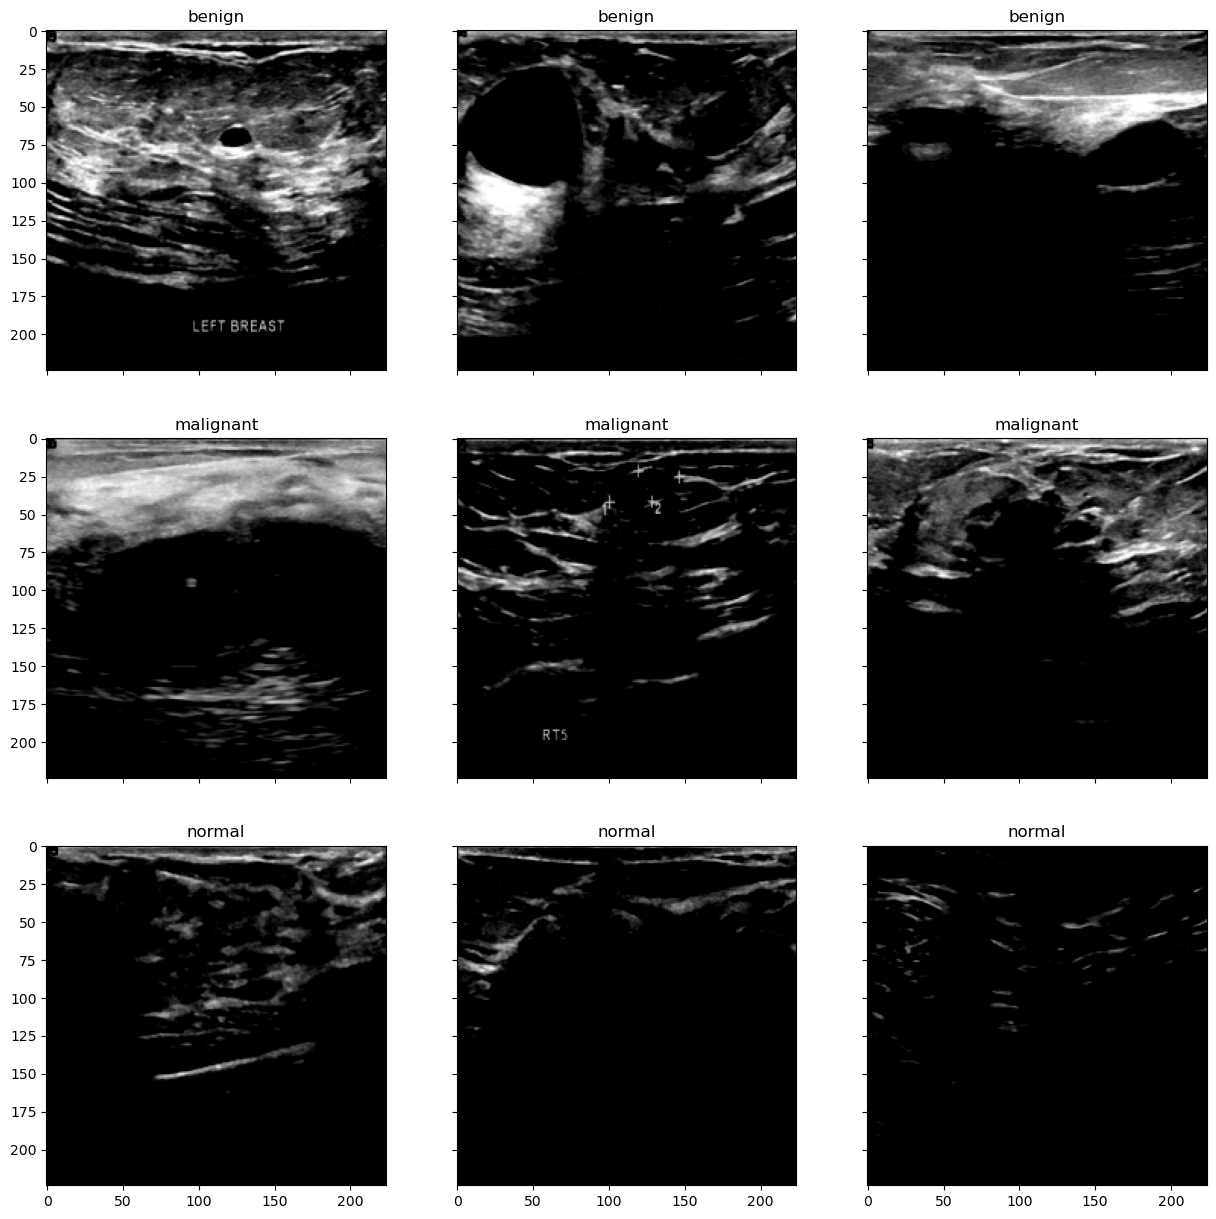

In [4]:
classes = dataset.classes
max_images_per_class = 3

# Plote algumas imagens de cada classe
class_counts = {class_label: 0 for class_label in classes}
fig, axs = plt.subplots(len(classes), max_images_per_class, figsize=(15, 15))

for image, label in dataset:
    class_label = classes[label]

    # Vamos plotar até max_images_per_class imagens de cada classe
    if class_counts[class_label] < max_images_per_class:
        # Aplica as transformações e inverte o canal de cores para plotar
        image_tensor = transform(image)
        img = image_tensor.permute(1, 2, 0)
        
        # Adicione a imagem na figura atual
        axs[label, class_counts[class_label]].imshow(img)
        axs[label, class_counts[class_label]].set_title(class_label)

        class_counts[class_label] += 1

    # Pare de iterar pelo dataset se tivermos o suficiente para cada classe
    if all(count >= max_images_per_class for count in class_counts.values()):
        break

# Mostre a figura com todas as imagens
for ax in axs.flat:
    ax.label_outer()  # Oculta x labels e tick labels para subplots que não estão na borda inferior e esquerda.

plt.show()

In [5]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(IMAGE_SHAPE), 
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    test_transforms = transforms.Compose([transforms.Resize(IMAGE_SHAPE), 
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)

    return train_data, test_data, trainloader, testloader

train_data, test_data, trainloader, testloader = load_split_train_test(PATH, .2)
classes = train_data.classes

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Consideramos que existem 3 classes em seu conjunto de dados
num_classes = 3
# Ajustamos a camada de classificação do modelo
model.classifier = nn.Linear(in_features=model.classifier.in_features, 
                             out_features=num_classes)

net = model.to(device)

In [8]:
# Definindo perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

 10%|█         | 1/10 [00:36<05:29, 36.65s/it]

Epoch 1 - Training Loss: 1.7030525743961333, Validation Loss: 1.0574310223261516, Accuracy: 54.48717948717949%


 20%|██        | 2/10 [01:06<04:20, 32.50s/it]

Epoch 2 - Training Loss: 1.0287769317626954, Validation Loss: 1.0769994258880615, Accuracy: 53.205128205128204%


 30%|███       | 3/10 [01:35<03:38, 31.15s/it]

Epoch 3 - Training Loss: 1.0157460510730743, Validation Loss: 1.0207274556159973, Accuracy: 54.48717948717949%


 40%|████      | 4/10 [02:05<03:04, 30.68s/it]

Epoch 4 - Training Loss: 0.9992663502693176, Validation Loss: 1.0048912167549133, Accuracy: 54.48717948717949%


 50%|█████     | 5/10 [02:36<02:32, 30.57s/it]

Epoch 5 - Training Loss: 0.9678740620613098, Validation Loss: 0.9703319072723389, Accuracy: 53.205128205128204%


 60%|██████    | 6/10 [03:06<02:01, 30.46s/it]

Epoch 6 - Training Loss: 0.9863941133022308, Validation Loss: 1.0030657052993774, Accuracy: 54.48717948717949%


 70%|███████   | 7/10 [03:37<01:31, 30.55s/it]

Epoch 7 - Training Loss: 0.9716915965080262, Validation Loss: 1.030210296312968, Accuracy: 52.56410256410256%


 80%|████████  | 8/10 [04:07<01:01, 30.55s/it]

Epoch 8 - Training Loss: 0.9864682912826538, Validation Loss: 0.9859031836191813, Accuracy: 55.76923076923077%


 90%|█████████ | 9/10 [04:38<00:30, 30.62s/it]

Epoch 9 - Training Loss: 0.9200937390327454, Validation Loss: 0.9518000284830729, Accuracy: 55.76923076923077%


100%|██████████| 10/10 [05:09<00:00, 30.94s/it]

Epoch 10 - Training Loss: 0.8779702544212341, Validation Loss: 0.911257803440094, Accuracy: 62.82051282051282%
Finished Training


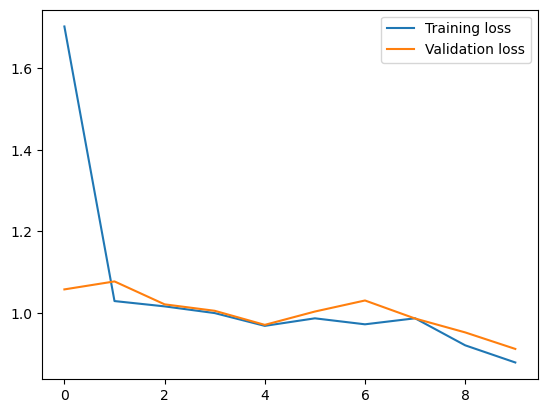

In [9]:
# Treinamento da rede
train_losses, test_losses = [], []
for epoch in tqdm(range(10)):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs.logits, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    accuracy = 100.0 * correct / total

    print(f"Epoch {epoch+1} - Training Loss: {running_loss/len(trainloader)}, Validation Loss: {test_loss/len(testloader)}, Accuracy: {accuracy}%")
    
    # Passar a perda de validação para o scheduler
    scheduler.step(test_loss)

print('Finished Training')

# Plotagem das curvas de treinamento e validação
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()
plt.show()

In [10]:
# Teste final de acuracia dos dados, matriz de confusão e f1 score

y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net(inputs.to(device))
        _, predicted = torch.max(outputs.logits, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.to(device).tolist())

print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

F1 Score: 0.5723390126173272
Classification Report:
              precision    recall  f1-score   support

      benign       0.64      0.86      0.73        85
   malignant       0.60      0.51      0.55        49
      normal       0.00      0.00      0.00        22

    accuracy                           0.63       156
   macro avg       0.41      0.46      0.43       156
weighted avg       0.54      0.63      0.57       156



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
